In [109]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
from monai.networks.nets import SwinUNETR
from monai.transforms import Transform
from monai.transforms import Compose, Flipd, Rotate90d, RandFlipd, RandRotate90d, RandSpatialCropd
import warnings
warnings.filterwarnings("ignore")
from monai.data import CacheDataset, DataLoader
import torch.nn.functional as F 
import zipfile
from tqdm import tqdm
import wandb
from datetime import datetime
from monai.transforms import Compose, Lambda
from monai.transforms import MapTransform
### our modules
from dataset import *
from training import *
from testing import *
from preprocessing import *
from models import *
from regularization import *

# Install additional packages 
#!pip install scikit-image
#!pip install wandb
#!pip install monai==1.2.0        
#!pip install imagecodecs
#!pip install opencv-python
#!pip install einops
#!pip install pyyaml

In [110]:
# Load config
with open("configs.yaml", "r") as f:
    config = yaml.safe_load(f)
    
dataset = config["dataset_paths"][config["dataset_index"]]
if not os.path.exists(dataset):
    print("Please update your data path to an existing folder.")
elif not set(["training", "test"]).issubset(set(os.listdir(dataset))):
    print("Please update your data path to the correct folder (should contain train and test folders).")
else:
    print(f"Congrats! You selected the correct folder : {dataset}")

Congrats! You selected the correct folder : ../datasets/DRIVE_dataset/datasets/


In [111]:
## configs

# Device
##device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if config["device"] == "auto" else torch.device(config["device"])
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

# Loss function
##loss_fn = DiceLoss(sigmoid=True, batch=True) if config["loss"] == "DiceLoss" else None  # Extend as needed

batch_size = config["batch_size"]
num_workers = config["num_workers"]
n_epochs = config["n_epochs"]
ensemble_models = config["ensemble_models"]
save_path = config["save_path"]
split_ratio = config["split_ratio"]

The used device is cuda:2


## Dataset with Monai

In [113]:
def build_dict_vessels(data_path, mode='training'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'train' or 'test'.
        
    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of images and masks.
    """
    # test if mode is correct
    if mode not in ["training", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    # list all files in directory, including the path
    paths_retina = glob.glob(os.path.join(data_path, mode, 'images', '*.tif'))
    #print(paths_retina)
        
    for retina_path in paths_retina:
        image_index = os.path.basename(retina_path).split('_')[0]
        mask_path = os.path.join(data_path, mode, '1st_manual', f'{image_index}_manual1.gif')
        #padding_mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}_mask.gif')
        padding_mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}_{mode}_mask.gif')

        #print(padding_mask_path)

        entry = {'img': retina_path,
                 'name': filename}

        # Add segmentation mask if it exists
        if os.path.exists(mask_path):
            #print("mask exist")
            entry['mask'] = mask_path

        # Add valid region mask (padding mask) if it exists
        if os.path.exists(padding_mask_path):
            #print("padding_mask exist")

            entry['valid_mask'] = padding_mask_path

        dicts.append(entry)

    return dicts

class LoadVesselData(Transform):
    """
    This custom Monai transform loads and processes data from the rib segmentation dataset.
    It handles RGB image loading, resizing, normalization, and binary mask conversion.
    """
    def __init__(self, keys=None):
        super().__init__()
        self.keys = keys

    def __call__(self, sample):
        try:
            # Load and process the image
            image = Image.open(sample['img']).convert('L')
            image = image.resize((512, 512), resample=Image.Resampling.NEAREST)
            image = np.array(image, dtype=np.float32) / 255.0
            image = torch.from_numpy(image).unsqueeze(0)  # [1, H, W]

            # Initialize output dictionary
            output = {
                'img': image,
                'img_meta_dict': {'affine': np.eye(2)},
                'name': sample.get('name', 'unknown')  

            }

            # Load segmentation mask if it exists
            if 'mask' in sample and os.path.exists(sample['mask']):
                mask = Image.open(sample['mask']).convert('L')
                mask = mask.resize((512, 512), resample=Image.Resampling.NEAREST)
                mask = np.array(mask, dtype=np.uint8)
                mask = np.where(mask == 255, 1, 0)
                mask = torch.from_numpy(mask).unsqueeze(0).float()
                output['mask'] = mask
                output['mask_meta_dict'] = {'affine': np.eye(2)}

            # Load valid (padding) mask if it exists
            if 'valid_mask' in sample and os.path.exists(sample['valid_mask']):
                valid_mask = Image.open(sample['valid_mask']).convert('L')
                valid_mask = valid_mask.resize((512, 512), resample=Image.Resampling.NEAREST)
                valid_mask = np.array(valid_mask, dtype=np.uint8)
                valid_mask = np.where(valid_mask == 255, 1, 0)
                valid_mask = torch.from_numpy(valid_mask).unsqueeze(0).float()
                output['valid_mask'] = valid_mask

            return output

        except Exception as e:
            print(f"Error processing file: {e}")
            return None



In [114]:
from dataset_stare import *

if config['combination']:
    print("Using STARE+DRIVE")
    main_path = "../datasets"
    stare_images_dir = f"{main_path}/STARE_dataset/images"
    stare_masks_dir = f"{main_path}/STARE_dataset/labels-ah"
    dataset = config["dataset_paths"][config["dataset_index"]] ## Drive dataset

    stare_dicts = build_dict_stare(stare_images_dir, stare_masks_dir)
    drive_dicts = build_dict_vessels(dataset, mode="training")
    train_dict_list = drive_dicts + stare_dicts
    ###test_dict_list = build_dict_vessels(dataset, mode='test')
    
##train_dict_list = build_dict_vessels(dataset, mode='training')
test_dict_list = build_dict_vessels(dataset, mode='test')

print(f'Number of samples in the training dataset: {len(train_dict_list)}')
print(f'Number of samples in the test dataset: {len(test_dict_list)}')

Using STARE+DRIVE
Number of samples in the training dataset: 40
Number of samples in the test dataset: 20


# Data Augmentation

In [116]:
# Don't run this if you don't want augmentations

## to fix
###train_processed_list, test_processed_list = apply_augmentation(train_dict_list, test_dict_list)

# DataLoaders

In [117]:
train_transforms = Compose([
    LoadVesselData()
])
train_dataset = monai.data.CacheDataset(
    data=train_dict_list, 
    transform = train_transforms
)

train_dataset, val_dataset = split_dataset(train_dataset, train_ratio=split_ratio)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)
print(type(train_dataloader))
validation_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)

Loading dataset: 100%|██████████| 40/40 [00:00<00:00, 59.29it/s]

Dataset split: 32 training samples, 8 testing samples.
<class 'monai.data.dataloader.DataLoader'>


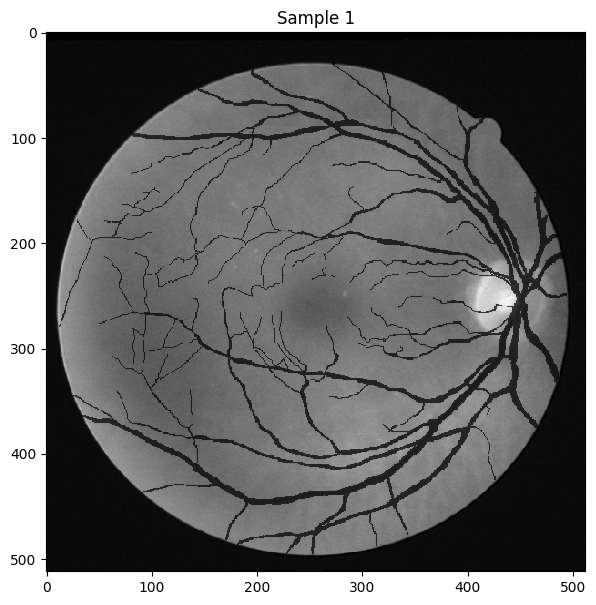

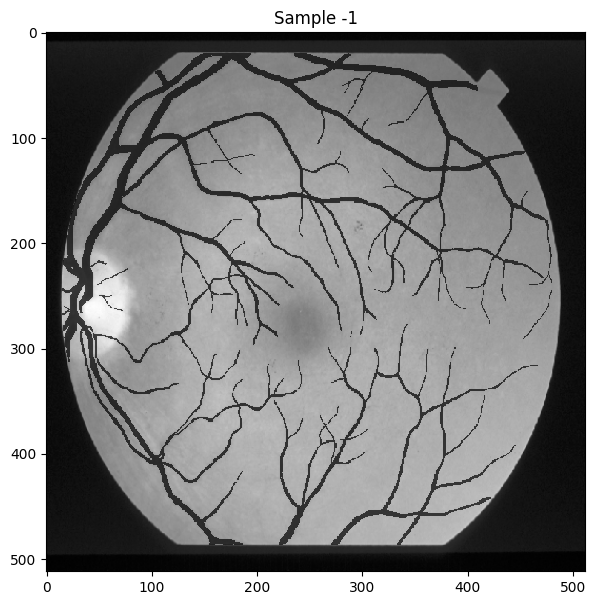

In [118]:
for i in range(len(train_dataset)):
    visualize_vessel_sample(train_dataset[1], title=f"Sample {i+1}")
    visualize_vessel_sample(train_dataset[-1], title=f"Sample {i-1}")
    break

In [119]:
for batch_data in train_dataloader:
    print("Image shape:", batch_data["img"].shape)  # Expected: [batch_size, 1, 512, 512]
    break

Image shape: torch.Size([4, 1, 512, 512])


# Models

In [25]:
# Setting up the neural network
##device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")


In [70]:
models = build_ensemble_models(config, device)
print(f"Loaded {len(models)} models: {[type(m).__name__ for m in models]}")

Loaded 2 models: ['SwinUNETR', 'UNetWithDropout']


# Training

In [24]:
import torch
import wandb
from tqdm import tqdm
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete
from regularization import *
import monai

import torch.nn.functional as F

def masked_loss(pred, target, valid_mask, criterion):##torch.nn.BCEWithLogitsLoss(reduction='none')):
    loss_map = criterion(pred, target)
    masked_loss = loss_map * valid_mask
    return masked_loss.sum() / valid_mask.sum()


def train(model, epochs, train_dataloader, validation_loader, optimizer,loss_function,n,early_stopping, device):
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    post_pred = AsDiscrete(threshold=0.5)
    post_label = AsDiscrete(threshold=0.5)
    
    best_val_loss = float("inf")
    best_model_path = f"{config['save_model']}/{model.__class__.__name__}_best.pt"

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()    
        epoch_loss = 0.0
        step = 0

        for batch_data in train_dataloader:
            step += 1
            optimizer.zero_grad()

            imgs = batch_data["img"].float().to(device)
            masks = batch_data["mask"].float().to(device)
            if "valid_mask" in batch_data:
                valid_mask = batch_data["valid_mask"].float().to(device)
            else:
                valid_mask = torch.ones_like(batch_data["mask"]).float().to(device)

            preds = model(imgs)

            # Use masked loss
            criterion = create_loss(config)
            loss = masked_loss(preds, masks, valid_mask, criterion)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / step
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {train_loss:.4f}")

        # ----- VALIDATION -----
        step = 0
        val_loss = 0
        correct_pixels = 0
        total_pixels = 0

        dice_metric.reset()
        model.eval()
        with torch.no_grad():
            for batch_data in validation_loader:
                step += 1

                imgs = batch_data["img"].float().to(device)
                masks = batch_data["mask"].float().to(device)

                if "valid_mask" in batch_data:
                    valid_mask = batch_data["valid_mask"].float().to(device)
                else:
                    valid_mask = torch.ones_like(masks).float().to(device)

                # Forward pass
                outputs = model(imgs)

                # Compute masked loss
                loss = masked_loss(outputs, masks, valid_mask,criterion)
                val_loss += loss.item()

                # Apply sigmoid and threshold
                preds = torch.sigmoid(outputs) > 0.5

                # Apply valid mask for accuracy and Dice
                masked_preds = preds.float() * valid_mask
                masked_targets = masks * valid_mask

                # Accuracy
                correct_pixels += (masked_preds == masked_targets).sum().item()
                total_pixels += valid_mask.sum().item()  # Count only valid pixels

                # Dice Score
                dice_metric(masked_preds, masked_targets)

            val_loss = val_loss / step
            accuracy = correct_pixels / total_pixels
            mean_dice = dice_metric.aggregate().item()
            dice_metric.reset()  
            
            log_to_wandb(epoch, train_loss, val_loss, accuracy, mean_dice, batch_data, outputs)

            # Check if this is the best model so far
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"✅ Best model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")

            # Early stopping (if past warmup)
            if epoch >= 40:
                early_stopping(val_loss)
                if early_stopping.early_stop:
                    print("🛑 Early stopping triggered.")
                    break
                    
def log_to_wandb(epoch, train_loss, val_loss, accuracy, mean_dice, batch_data, outputs):
    """Logs metrics and image/mask visualizations to Weights & Biases."""
    
    imgs = batch_data['img'].detach().cpu()
    masks = batch_data['mask'].detach().cpu()
    preds = outputs.detach().cpu()

    # Optional valid_mask
    valid_mask = batch_data.get('valid_mask', None)
    if valid_mask is not None:
        valid_mask = valid_mask.detach().cpu()
    else:
        valid_mask = torch.ones_like(masks)  # fallback to all-valid

    log_imgs = []
    for img, pred, gt, vmask in zip(imgs, preds, masks, valid_mask):
        # Apply sigmoid to raw logits and binarize
        pred = torch.sigmoid(pred)
        pred_bin = torch.round(pred) * vmask  # apply valid mask
        gt_bin = gt * vmask

        # Log image with overlaid predictions and ground truth
        log_imgs.append(wandb.Image(img.squeeze(), masks=wandb_masks(pred_bin, gt_bin)))

    # Log everything
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'pixelaccuracy': accuracy,
        'mean_dice': mean_dice,
        'results': log_imgs
    })
    


def wandb_masks(mask_output, mask_gt):
    """Creates a dictionary of masks formatted for WandB image overlay."""
    class_labels = {1: 'vessels'}

    return {
        'predictions': {'mask_data': mask_output.squeeze().numpy(), 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt.squeeze().numpy(), 'class_labels': class_labels}
    }


In [26]:
def from_compose_to_list(transform):
    return transform.transforms

torch.manual_seed(42)
np.random.seed(42)
import random 
random.seed(42)

torch.cuda.empty_cache()

# defining the dictionary mapping each model to its Dice coefficient for l;ater computation
model_dice_dict = {}

for model in models:
    ##wandb.finish()  # ensures a clean slate

    print(f"Starting model: {model.__class__.__name__}")
    n = sum(p.numel() for p in model.parameters() if p.requires_grad) # number of parameters
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'], delta=0.001)

    loss_function = create_loss(config)
    
    optimizer = create_optimizer(config, model)
    
    now = datetime.now()
    now_str = now.strftime("%Y-%m-%d_%H-%M-%S")
    print(now_str)

    run = wandb.init(
        project='DRIVE',
        name=now_str,
        config={
            #'models': str([type(m).__name__ for m in models]),
            'loss function': str(loss_function), 
            'lr': optimizer.param_groups[0]["lr"],
            'transform': from_compose_to_list(train_transforms),
            'batch_size': train_dataloader.batch_size,
            'layers': 5,
            'parameters': n,
            'early_stopping_patience': str(config['early_stopping_patience'])    
        }
    )
    wandb.config.update(config)
    run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

    ### training loop
    epochs = n_epochs
    train(model, epochs, train_dataloader, validation_loader, optimizer,loss_function,n,early_stopping, device)
    
    # Store the network parameters   
    os.makedirs(config['save_model'], exist_ok=True)
    torch.save(model.state_dict(), f"{config['save_model']}/{model.__class__.__name__}.pt")
    print(f"Model saved to {config['save_model']}")
    run.finish()
    
    api = wandb.Api()
    run = api.run(f"DRIVE/{run_id}")
    
    # Final Dice
    metric_fn = monai.metrics.DiceMetric()
    dice = compute_metric(validation_loader, model, metric_fn,device)
    run.summary["dice"] = dice
    run.summary.update()
    print(f"Dice on validation set: {dice:.3f}")

    model_dice_dict[model] = dice
    
    # Final Hausdorff distance
    metric_fn = monai.metrics.HausdorffDistanceMetric()
    HausdorffDistance = compute_metric(validation_loader, model, metric_fn,device)
    run.summary["HausdorffDistance"] = HausdorffDistance
    run.summary.update()
    print(f"HausdorffDistance on validation set: {HausdorffDistance:.3f}")

Starting model: SwinUNETR
2025-04-04_13-46-15


Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/250], Avg Loss: 0.7271


Epochs:   0%|          | 1/250 [00:18<1:16:36, 18.46s/it]

✅ Best model saved at epoch 1 with val_loss: 0.5931
Epoch [2/250], Avg Loss: 0.5663


Epochs:   1%|          | 2/250 [00:33<1:08:04, 16.47s/it]

✅ Best model saved at epoch 2 with val_loss: 0.4998
Epoch [3/250], Avg Loss: 0.5086


Epochs:   1%|          | 3/250 [00:48<1:05:31, 15.92s/it]

✅ Best model saved at epoch 3 with val_loss: 0.4601
Epoch [4/250], Avg Loss: 0.4644


Epochs:   2%|▏         | 4/250 [01:03<1:03:58, 15.60s/it]

✅ Best model saved at epoch 4 with val_loss: 0.4361
Epoch [5/250], Avg Loss: 0.4362


Epochs:   2%|▏         | 5/250 [01:19<1:03:01, 15.43s/it]

✅ Best model saved at epoch 5 with val_loss: 0.3939
Epoch [6/250], Avg Loss: 0.4100


Epochs:   2%|▏         | 6/250 [01:34<1:02:19, 15.33s/it]

✅ Best model saved at epoch 6 with val_loss: 0.3687
Epoch [7/250], Avg Loss: 0.3849


Epochs:   3%|▎         | 7/250 [01:49<1:01:37, 15.21s/it]

✅ Best model saved at epoch 7 with val_loss: 0.3468
Epoch [8/250], Avg Loss: 0.3690


Epochs:   3%|▎         | 8/250 [02:04<1:01:20, 15.21s/it]

✅ Best model saved at epoch 8 with val_loss: 0.3286
Epoch [9/250], Avg Loss: 0.3514


Epochs:   4%|▎         | 9/250 [02:19<1:00:59, 15.18s/it]

✅ Best model saved at epoch 9 with val_loss: 0.3188
Epoch [10/250], Avg Loss: 0.3414


Epochs:   4%|▍         | 10/250 [02:34<1:00:40, 15.17s/it]

✅ Best model saved at epoch 10 with val_loss: 0.3058
Epoch [11/250], Avg Loss: 0.3323


Epochs:   4%|▍         | 11/250 [02:49<1:00:17, 15.13s/it]

✅ Best model saved at epoch 11 with val_loss: 0.2939
Epoch [12/250], Avg Loss: 0.3213


Epochs:   5%|▍         | 12/250 [03:04<59:53, 15.10s/it]  

✅ Best model saved at epoch 12 with val_loss: 0.2918
Epoch [13/250], Avg Loss: 0.3108


Epochs:   5%|▌         | 13/250 [03:19<59:41, 15.11s/it]

✅ Best model saved at epoch 13 with val_loss: 0.2817
Epoch [14/250], Avg Loss: 0.3070


Epochs:   6%|▌         | 14/250 [03:34<59:25, 15.11s/it]

✅ Best model saved at epoch 14 with val_loss: 0.2803
Epoch [15/250], Avg Loss: 0.2962


Epochs:   6%|▌         | 15/250 [03:50<59:11, 15.11s/it]

✅ Best model saved at epoch 15 with val_loss: 0.2745
Epoch [16/250], Avg Loss: 0.2962


Epochs:   6%|▋         | 16/250 [04:04<58:37, 15.03s/it]

Epoch [17/250], Avg Loss: 0.2916


Epochs:   7%|▋         | 17/250 [04:19<58:26, 15.05s/it]

✅ Best model saved at epoch 17 with val_loss: 0.2628
Epoch [18/250], Avg Loss: 0.2871


Epochs:   7%|▋         | 18/250 [04:35<58:19, 15.09s/it]

✅ Best model saved at epoch 18 with val_loss: 0.2582
Epoch [19/250], Avg Loss: 0.2823


Epochs:   8%|▊         | 19/250 [04:50<58:05, 15.09s/it]

✅ Best model saved at epoch 19 with val_loss: 0.2509
Epoch [20/250], Avg Loss: 0.2785


Epochs:   8%|▊         | 20/250 [05:05<57:32, 15.01s/it]

Epoch [21/250], Avg Loss: 0.2743


Epochs:   8%|▊         | 21/250 [05:20<57:22, 15.03s/it]

✅ Best model saved at epoch 21 with val_loss: 0.2489
Epoch [22/250], Avg Loss: 0.2688


Epochs:   9%|▉         | 22/250 [05:35<56:57, 14.99s/it]

Epoch [23/250], Avg Loss: 0.2636


Epochs:   9%|▉         | 23/250 [05:50<56:53, 15.04s/it]

✅ Best model saved at epoch 23 with val_loss: 0.2376
Epoch [24/250], Avg Loss: 0.2613


Epochs:  10%|▉         | 24/250 [06:05<56:32, 15.01s/it]

Epoch [25/250], Avg Loss: 0.2604


Epochs:  10%|█         | 25/250 [06:20<56:31, 15.07s/it]

✅ Best model saved at epoch 25 with val_loss: 0.2351
Epoch [26/250], Avg Loss: 0.2605


Epochs:  10%|█         | 26/250 [06:35<56:10, 15.05s/it]

Epoch [27/250], Avg Loss: 0.2520


Epochs:  11%|█         | 27/250 [06:50<56:02, 15.08s/it]

✅ Best model saved at epoch 27 with val_loss: 0.2336
Epoch [28/250], Avg Loss: 0.2508


Epochs:  11%|█         | 28/250 [07:05<55:58, 15.13s/it]

✅ Best model saved at epoch 28 with val_loss: 0.2252
Epoch [29/250], Avg Loss: 0.2525


Epochs:  12%|█▏        | 29/250 [07:20<55:27, 15.06s/it]

Epoch [30/250], Avg Loss: 0.2505


Epochs:  12%|█▏        | 30/250 [07:36<55:35, 15.16s/it]

✅ Best model saved at epoch 30 with val_loss: 0.2240
Epoch [31/250], Avg Loss: 0.2482


Epochs:  12%|█▏        | 31/250 [07:50<55:02, 15.08s/it]

Epoch [32/250], Avg Loss: 0.2430


Epochs:  13%|█▎        | 32/250 [08:06<55:10, 15.18s/it]

✅ Best model saved at epoch 32 with val_loss: 0.2218
Epoch [33/250], Avg Loss: 0.2416


Epochs:  13%|█▎        | 33/250 [08:22<55:36, 15.37s/it]

Epoch [34/250], Avg Loss: 0.2389


Epochs:  14%|█▎        | 34/250 [08:37<54:49, 15.23s/it]

Epoch [35/250], Avg Loss: 0.2363


Epochs:  14%|█▍        | 35/250 [08:52<54:30, 15.21s/it]

✅ Best model saved at epoch 35 with val_loss: 0.2185
Epoch [36/250], Avg Loss: 0.2327


Epochs:  14%|█▍        | 36/250 [09:07<54:18, 15.23s/it]

✅ Best model saved at epoch 36 with val_loss: 0.2161
Epoch [37/250], Avg Loss: 0.2333


Epochs:  15%|█▍        | 37/250 [09:22<53:49, 15.16s/it]

Epoch [38/250], Avg Loss: 0.2266


Epochs:  15%|█▌        | 38/250 [09:37<53:34, 15.16s/it]

✅ Best model saved at epoch 38 with val_loss: 0.2147
Epoch [39/250], Avg Loss: 0.2275


Epochs:  16%|█▌        | 39/250 [09:52<53:24, 15.19s/it]

Epoch [40/250], Avg Loss: 0.2250


Epochs:  16%|█▌        | 40/250 [10:08<53:05, 15.17s/it]

Epoch [41/250], Avg Loss: 0.2245


Epochs:  16%|█▋        | 41/250 [10:22<52:29, 15.07s/it]

Epoch [42/250], Avg Loss: 0.2197


Epochs:  17%|█▋        | 42/250 [10:38<52:18, 15.09s/it]

✅ Best model saved at epoch 42 with val_loss: 0.2140
Epoch [43/250], Avg Loss: 0.2182


Epochs:  17%|█▋        | 43/250 [10:53<52:06, 15.10s/it]

✅ Best model saved at epoch 43 with val_loss: 0.2112
Epoch [44/250], Avg Loss: 0.2175


Epochs:  18%|█▊        | 44/250 [11:08<51:44, 15.07s/it]

EarlyStopping counter: 1 / 10
Epoch [45/250], Avg Loss: 0.2133


Epochs:  18%|█▊        | 45/250 [11:23<52:10, 15.27s/it]

✅ Best model saved at epoch 45 with val_loss: 0.2110
EarlyStopping counter: 2 / 10
Epoch [46/250], Avg Loss: 0.2091


Epochs:  18%|█▊        | 46/250 [11:39<51:46, 15.23s/it]

EarlyStopping counter: 3 / 10
Epoch [47/250], Avg Loss: 0.2058


Epochs:  19%|█▉        | 47/250 [11:54<51:26, 15.21s/it]

✅ Best model saved at epoch 47 with val_loss: 0.2074
Epoch [48/250], Avg Loss: 0.2032


Epochs:  19%|█▉        | 48/250 [12:09<50:53, 15.12s/it]

EarlyStopping counter: 1 / 10
Epoch [49/250], Avg Loss: 0.2020


Epochs:  20%|█▉        | 49/250 [12:23<50:19, 15.02s/it]

EarlyStopping counter: 2 / 10
Epoch [50/250], Avg Loss: 0.2024


Epochs:  20%|██        | 50/250 [12:38<49:55, 14.98s/it]

EarlyStopping counter: 3 / 10
Epoch [51/250], Avg Loss: 0.1998


Epochs:  20%|██        | 51/250 [12:53<49:43, 14.99s/it]

EarlyStopping counter: 4 / 10
Epoch [52/250], Avg Loss: 0.2003


Epochs:  21%|██        | 52/250 [13:09<50:03, 15.17s/it]

✅ Best model saved at epoch 52 with val_loss: 0.2073
EarlyStopping counter: 5 / 10
Epoch [53/250], Avg Loss: 0.1961


Epochs:  21%|██        | 53/250 [13:24<49:49, 15.18s/it]

EarlyStopping counter: 6 / 10
Epoch [54/250], Avg Loss: 0.1921


Epochs:  22%|██▏       | 54/250 [13:39<49:35, 15.18s/it]

✅ Best model saved at epoch 54 with val_loss: 0.2070
EarlyStopping counter: 7 / 10
Epoch [55/250], Avg Loss: 0.1881


Epochs:  22%|██▏       | 55/250 [13:54<49:16, 15.16s/it]

✅ Best model saved at epoch 55 with val_loss: 0.2046
Epoch [56/250], Avg Loss: 0.1831


Epochs:  22%|██▏       | 56/250 [14:09<48:49, 15.10s/it]

EarlyStopping counter: 1 / 10
Epoch [57/250], Avg Loss: 0.1866


Epochs:  23%|██▎       | 57/250 [14:24<48:33, 15.10s/it]

EarlyStopping counter: 2 / 10
Epoch [58/250], Avg Loss: 0.1873


Epochs:  23%|██▎       | 58/250 [14:39<48:15, 15.08s/it]

EarlyStopping counter: 3 / 10
Epoch [59/250], Avg Loss: 0.1851


Epochs:  24%|██▎       | 59/250 [14:55<48:23, 15.20s/it]

✅ Best model saved at epoch 59 with val_loss: 0.2044
EarlyStopping counter: 4 / 10
Epoch [60/250], Avg Loss: 0.1803


Epochs:  24%|██▍       | 60/250 [15:10<47:55, 15.13s/it]

EarlyStopping counter: 5 / 10
Epoch [61/250], Avg Loss: 0.1782


Epochs:  24%|██▍       | 61/250 [15:25<47:46, 15.17s/it]

EarlyStopping counter: 6 / 10
Epoch [62/250], Avg Loss: 0.1793


Epochs:  25%|██▍       | 62/250 [15:40<47:18, 15.10s/it]

EarlyStopping counter: 7 / 10
Epoch [63/250], Avg Loss: 0.1769


Epochs:  25%|██▌       | 63/250 [15:55<46:54, 15.05s/it]

EarlyStopping counter: 8 / 10
Epoch [64/250], Avg Loss: 0.1725


Epochs:  26%|██▌       | 64/250 [16:10<46:28, 14.99s/it]

EarlyStopping counter: 9 / 10
Epoch [65/250], Avg Loss: 0.1713


Epochs:  26%|██▌       | 64/250 [16:25<47:43, 15.40s/it]

EarlyStopping counter: 10 / 10
🛑 Early stopping triggered.


Model saved to ../saved_models/


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
mean_dice,▁▅▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇██▇███▇████████████████
pixelaccuracy,▁▅▄▆▆▇▇▇▇▇▇█▇▇██████████████████████████
train_loss,█▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,64
mean_dice,0.79847
pixelaccuracy,1.05646
train_loss,0.17132
val_loss,0.20528


Dice on validation set: 0.779
Epoch [2/250], Avg Loss: 0.8086


Epochs:   1%|          | 2/250 [00:07<15:51,  3.84s/it]

Epoch [3/250], Avg Loss: 0.7802


Epochs:   1%|          | 3/250 [00:10<14:54,  3.62s/it]

Epoch [4/250], Avg Loss: 0.7621


Epochs:   2%|▏         | 4/250 [00:14<14:39,  3.58s/it]

✅ Best model saved at epoch 4 with val_loss: 0.8474
Epoch [5/250], Avg Loss: 0.7465


Epochs:   2%|▏         | 5/250 [00:18<14:38,  3.59s/it]

✅ Best model saved at epoch 5 with val_loss: 0.8387
Epoch [6/250], Avg Loss: 0.7376


Epochs:   2%|▏         | 6/250 [00:22<15:12,  3.74s/it]

✅ Best model saved at epoch 6 with val_loss: 0.8004
Epoch [7/250], Avg Loss: 0.7303


Epochs:   3%|▎         | 7/250 [00:25<15:08,  3.74s/it]

✅ Best model saved at epoch 7 with val_loss: 0.7689
Epoch [8/250], Avg Loss: 0.7225


Epochs:   3%|▎         | 8/250 [00:29<15:04,  3.74s/it]

✅ Best model saved at epoch 8 with val_loss: 0.7658
Epoch [9/250], Avg Loss: 0.7138


Epochs:   4%|▎         | 9/250 [00:33<14:55,  3.72s/it]

✅ Best model saved at epoch 9 with val_loss: 0.7172
Epoch [10/250], Avg Loss: 0.7072


Epochs:   4%|▍         | 10/250 [00:37<15:09,  3.79s/it]

✅ Best model saved at epoch 10 with val_loss: 0.6984
Epoch [11/250], Avg Loss: 0.7071


Epochs:   4%|▍         | 11/250 [00:41<15:16,  3.84s/it]

Epoch [12/250], Avg Loss: 0.6927


Epochs:   5%|▍         | 12/250 [00:44<15:13,  3.84s/it]

✅ Best model saved at epoch 12 with val_loss: 0.6909
Epoch [13/250], Avg Loss: 0.6808


Epochs:   5%|▌         | 13/250 [00:48<14:40,  3.72s/it]

Epoch [14/250], Avg Loss: 0.6869


Epochs:   6%|▌         | 14/250 [00:51<14:25,  3.67s/it]

✅ Best model saved at epoch 14 with val_loss: 0.6762
Epoch [15/250], Avg Loss: 0.6606


Epochs:   6%|▌         | 15/250 [00:55<14:25,  3.68s/it]

Epoch [16/250], Avg Loss: 0.6593


Epochs:   6%|▋         | 16/250 [00:59<14:19,  3.67s/it]

Epoch [17/250], Avg Loss: 0.6299


Epochs:   7%|▋         | 17/250 [01:03<14:59,  3.86s/it]

✅ Best model saved at epoch 17 with val_loss: 0.6275
Epoch [18/250], Avg Loss: 0.6354


Epochs:   7%|▋         | 18/250 [01:07<14:32,  3.76s/it]

✅ Best model saved at epoch 18 with val_loss: 0.6007
Epoch [19/250], Avg Loss: 0.6113


Epochs:   8%|▊         | 19/250 [01:10<14:10,  3.68s/it]

Epoch [20/250], Avg Loss: 0.6006


Epochs:   8%|▊         | 20/250 [01:14<14:08,  3.69s/it]

✅ Best model saved at epoch 20 with val_loss: 0.5472
Epoch [21/250], Avg Loss: 0.5783


Epochs:   8%|▊         | 21/250 [01:18<14:17,  3.74s/it]

Epoch [22/250], Avg Loss: 0.5714


Epochs:   9%|▉         | 22/250 [01:21<14:01,  3.69s/it]

✅ Best model saved at epoch 22 with val_loss: 0.5244
Epoch [23/250], Avg Loss: 0.5481


Epochs:   9%|▉         | 23/250 [01:25<13:55,  3.68s/it]

✅ Best model saved at epoch 23 with val_loss: 0.5216
Epoch [24/250], Avg Loss: 0.5183


Epochs:  10%|▉         | 24/250 [01:29<13:49,  3.67s/it]

Epoch [25/250], Avg Loss: 0.5126


Epochs:  10%|█         | 25/250 [01:32<13:50,  3.69s/it]

✅ Best model saved at epoch 25 with val_loss: 0.5016
Epoch [26/250], Avg Loss: 0.5128


Epochs:  10%|█         | 26/250 [01:36<13:44,  3.68s/it]

✅ Best model saved at epoch 26 with val_loss: 0.4695
Epoch [27/250], Avg Loss: 0.4753


Epochs:  11%|█         | 27/250 [01:40<14:02,  3.78s/it]

✅ Best model saved at epoch 27 with val_loss: 0.4562
Epoch [28/250], Avg Loss: 0.4711


Epochs:  11%|█         | 28/250 [01:44<13:43,  3.71s/it]

Epoch [29/250], Avg Loss: 0.4415


Epochs:  12%|█▏        | 29/250 [01:47<13:48,  3.75s/it]

✅ Best model saved at epoch 29 with val_loss: 0.4112
Epoch [30/250], Avg Loss: 0.4448


Epochs:  12%|█▏        | 30/250 [01:52<14:17,  3.90s/it]

Epoch [31/250], Avg Loss: 0.4402


Epochs:  12%|█▏        | 31/250 [01:55<14:06,  3.86s/it]

✅ Best model saved at epoch 31 with val_loss: 0.3777
Epoch [32/250], Avg Loss: 0.4309


Epochs:  13%|█▎        | 32/250 [01:59<13:42,  3.77s/it]

✅ Best model saved at epoch 32 with val_loss: 0.3641
Epoch [33/250], Avg Loss: 0.3997


Epochs:  13%|█▎        | 33/250 [02:03<13:39,  3.77s/it]

✅ Best model saved at epoch 33 with val_loss: 0.3367
Epoch [34/250], Avg Loss: 0.4194


Epochs:  14%|█▎        | 34/250 [02:07<13:32,  3.76s/it]

Epoch [35/250], Avg Loss: 0.3959


Epochs:  14%|█▍        | 35/250 [02:10<13:34,  3.79s/it]

✅ Best model saved at epoch 35 with val_loss: 0.3218
Epoch [36/250], Avg Loss: 0.3819


Epochs:  14%|█▍        | 36/250 [02:14<13:10,  3.69s/it]

Epoch [37/250], Avg Loss: 0.4113


Epochs:  15%|█▍        | 37/250 [02:18<13:10,  3.71s/it]

Epoch [38/250], Avg Loss: 0.3572


Epochs:  15%|█▌        | 38/250 [02:21<13:18,  3.76s/it]

Epoch [39/250], Avg Loss: 0.3476


Epochs:  16%|█▌        | 39/250 [02:25<13:27,  3.83s/it]

✅ Best model saved at epoch 39 with val_loss: 0.3111
Epoch [40/250], Avg Loss: 0.3632


Epochs:  16%|█▌        | 40/250 [02:29<13:26,  3.84s/it]

✅ Best model saved at epoch 40 with val_loss: 0.2940
Epoch [41/250], Avg Loss: 0.3415


Epochs:  16%|█▋        | 41/250 [02:33<13:11,  3.79s/it]

Epoch [42/250], Avg Loss: 0.3587


Epochs:  17%|█▋        | 42/250 [02:37<13:03,  3.77s/it]

EarlyStopping counter: 1 / 10
Epoch [43/250], Avg Loss: 0.3606


Epochs:  17%|█▋        | 43/250 [02:40<12:52,  3.73s/it]

EarlyStopping counter: 2 / 10
Epoch [44/250], Avg Loss: 0.3376


Epochs:  18%|█▊        | 44/250 [02:44<12:58,  3.78s/it]

✅ Best model saved at epoch 44 with val_loss: 0.2816
Epoch [45/250], Avg Loss: 0.3369


Epochs:  18%|█▊        | 45/250 [02:48<12:48,  3.75s/it]

EarlyStopping counter: 1 / 10
Epoch [46/250], Avg Loss: 0.3430


Epochs:  18%|█▊        | 46/250 [02:52<13:01,  3.83s/it]

EarlyStopping counter: 2 / 10
Epoch [47/250], Avg Loss: 0.3442


Epochs:  19%|█▉        | 47/250 [02:56<12:52,  3.80s/it]

✅ Best model saved at epoch 47 with val_loss: 0.2731
Epoch [48/250], Avg Loss: 0.3036


Epochs:  19%|█▉        | 48/250 [03:00<12:48,  3.80s/it]

✅ Best model saved at epoch 48 with val_loss: 0.2707
Epoch [49/250], Avg Loss: 0.3223


Epochs:  20%|█▉        | 49/250 [03:03<12:28,  3.73s/it]

✅ Best model saved at epoch 49 with val_loss: 0.2641
Epoch [50/250], Avg Loss: 0.3139


Epochs:  20%|██        | 50/250 [03:07<12:25,  3.73s/it]

EarlyStopping counter: 1 / 10
Epoch [51/250], Avg Loss: 0.3073


Epochs:  20%|██        | 51/250 [03:11<12:46,  3.85s/it]

✅ Best model saved at epoch 51 with val_loss: 0.2621
Epoch [52/250], Avg Loss: 0.3279


Epochs:  21%|██        | 52/250 [03:15<13:01,  3.95s/it]

EarlyStopping counter: 1 / 10
Epoch [53/250], Avg Loss: 0.3104


Epochs:  21%|██        | 53/250 [03:19<13:20,  4.07s/it]

✅ Best model saved at epoch 53 with val_loss: 0.2581
Epoch [54/250], Avg Loss: 0.3087


Epochs:  22%|██▏       | 54/250 [03:23<13:02,  3.99s/it]

✅ Best model saved at epoch 54 with val_loss: 0.2531
Epoch [55/250], Avg Loss: 0.3017


Epochs:  22%|██▏       | 55/250 [03:27<12:22,  3.81s/it]

EarlyStopping counter: 1 / 10
Epoch [56/250], Avg Loss: 0.3008


Epochs:  22%|██▏       | 56/250 [03:30<12:03,  3.73s/it]

EarlyStopping counter: 2 / 10
Epoch [57/250], Avg Loss: 0.2879


Epochs:  23%|██▎       | 57/250 [03:34<11:53,  3.70s/it]

EarlyStopping counter: 3 / 10
Epoch [58/250], Avg Loss: 0.2985


Epochs:  23%|██▎       | 58/250 [03:37<11:38,  3.64s/it]

EarlyStopping counter: 4 / 10
Epoch [59/250], Avg Loss: 0.3034


Epochs:  24%|██▎       | 59/250 [03:41<11:44,  3.69s/it]

✅ Best model saved at epoch 59 with val_loss: 0.2505
Epoch [60/250], Avg Loss: 0.2793


Epochs:  24%|██▍       | 60/250 [03:45<11:50,  3.74s/it]

✅ Best model saved at epoch 60 with val_loss: 0.2434
Epoch [61/250], Avg Loss: 0.2899


Epochs:  24%|██▍       | 61/250 [03:49<11:45,  3.73s/it]

✅ Best model saved at epoch 61 with val_loss: 0.2431
EarlyStopping counter: 1 / 10
Epoch [62/250], Avg Loss: 0.2844


Epochs:  25%|██▍       | 62/250 [03:52<11:36,  3.71s/it]

EarlyStopping counter: 2 / 10
Epoch [63/250], Avg Loss: 0.2902


Epochs:  25%|██▌       | 63/250 [03:56<11:25,  3.67s/it]

✅ Best model saved at epoch 63 with val_loss: 0.2399
Epoch [64/250], Avg Loss: 0.2745


Epochs:  26%|██▌       | 64/250 [03:59<11:08,  3.60s/it]

EarlyStopping counter: 1 / 10
Epoch [65/250], Avg Loss: 0.2759


Epochs:  26%|██▌       | 65/250 [04:03<10:51,  3.52s/it]

EarlyStopping counter: 2 / 10
Epoch [66/250], Avg Loss: 0.2877


Epochs:  26%|██▋       | 66/250 [04:06<10:50,  3.54s/it]

✅ Best model saved at epoch 66 with val_loss: 0.2396
EarlyStopping counter: 3 / 10
Epoch [67/250], Avg Loss: 0.2655


Epochs:  27%|██▋       | 67/250 [04:10<10:55,  3.58s/it]

✅ Best model saved at epoch 67 with val_loss: 0.2350
Epoch [68/250], Avg Loss: 0.2694


Epochs:  27%|██▋       | 68/250 [04:13<10:50,  3.57s/it]

EarlyStopping counter: 1 / 10
Epoch [69/250], Avg Loss: 0.2675


Epochs:  28%|██▊       | 69/250 [04:17<10:49,  3.59s/it]

EarlyStopping counter: 2 / 10
Epoch [70/250], Avg Loss: 0.2791


Epochs:  28%|██▊       | 70/250 [04:21<10:36,  3.54s/it]

EarlyStopping counter: 3 / 10
Epoch [71/250], Avg Loss: 0.2772


Epochs:  28%|██▊       | 71/250 [04:24<10:28,  3.51s/it]

EarlyStopping counter: 4 / 10
Epoch [72/250], Avg Loss: 0.2871


Epochs:  29%|██▉       | 72/250 [04:28<10:40,  3.60s/it]

✅ Best model saved at epoch 72 with val_loss: 0.2329
Epoch [73/250], Avg Loss: 0.2643


Epochs:  29%|██▉       | 73/250 [04:31<10:23,  3.52s/it]

EarlyStopping counter: 1 / 10
Epoch [74/250], Avg Loss: 0.2675


Epochs:  30%|██▉       | 74/250 [04:35<10:33,  3.60s/it]

✅ Best model saved at epoch 74 with val_loss: 0.2264
Epoch [75/250], Avg Loss: 0.2596


Epochs:  30%|███       | 75/250 [04:38<10:16,  3.52s/it]

EarlyStopping counter: 1 / 10
Epoch [76/250], Avg Loss: 0.2551


Epochs:  30%|███       | 76/250 [04:42<10:09,  3.51s/it]

EarlyStopping counter: 2 / 10
Epoch [77/250], Avg Loss: 0.2668


Epochs:  31%|███       | 77/250 [04:46<10:22,  3.60s/it]

EarlyStopping counter: 3 / 10
Epoch [78/250], Avg Loss: 0.2637


Epochs:  31%|███       | 78/250 [04:49<10:36,  3.70s/it]

EarlyStopping counter: 4 / 10
Epoch [79/250], Avg Loss: 0.2684


Epochs:  32%|███▏      | 79/250 [04:53<10:16,  3.60s/it]

EarlyStopping counter: 5 / 10
Epoch [80/250], Avg Loss: 0.2618


Epochs:  32%|███▏      | 80/250 [04:56<10:01,  3.54s/it]

EarlyStopping counter: 6 / 10
Epoch [81/250], Avg Loss: 0.2609


Epochs:  32%|███▏      | 81/250 [05:00<09:54,  3.52s/it]

EarlyStopping counter: 7 / 10
Epoch [82/250], Avg Loss: 0.2515


Epochs:  33%|███▎      | 82/250 [05:03<09:48,  3.50s/it]

EarlyStopping counter: 8 / 10
Epoch [83/250], Avg Loss: 0.2519


Epochs:  33%|███▎      | 83/250 [05:07<09:47,  3.52s/it]

✅ Best model saved at epoch 83 with val_loss: 0.2194
Epoch [84/250], Avg Loss: 0.2639


Epochs:  34%|███▎      | 84/250 [05:10<09:41,  3.50s/it]

✅ Best model saved at epoch 84 with val_loss: 0.2187
EarlyStopping counter: 1 / 10
Epoch [85/250], Avg Loss: 0.2478


Epochs:  34%|███▍      | 85/250 [05:14<09:34,  3.48s/it]

EarlyStopping counter: 2 / 10
Epoch [86/250], Avg Loss: 0.2498


Epochs:  34%|███▍      | 86/250 [05:17<09:27,  3.46s/it]

EarlyStopping counter: 3 / 10
Epoch [87/250], Avg Loss: 0.2550


Epochs:  35%|███▍      | 87/250 [05:21<09:25,  3.47s/it]

EarlyStopping counter: 4 / 10
Epoch [88/250], Avg Loss: 0.2582


Epochs:  35%|███▌      | 88/250 [05:24<09:35,  3.55s/it]

EarlyStopping counter: 5 / 10
Epoch [89/250], Avg Loss: 0.2498


Epochs:  36%|███▌      | 89/250 [05:28<09:42,  3.62s/it]

EarlyStopping counter: 6 / 10
Epoch [90/250], Avg Loss: 0.2483


Epochs:  36%|███▌      | 90/250 [05:32<09:40,  3.63s/it]

EarlyStopping counter: 7 / 10
Epoch [91/250], Avg Loss: 0.2629


Epochs:  36%|███▋      | 91/250 [05:35<09:28,  3.57s/it]

EarlyStopping counter: 8 / 10
Epoch [92/250], Avg Loss: 0.2509


Epochs:  37%|███▋      | 92/250 [05:39<09:20,  3.55s/it]

EarlyStopping counter: 9 / 10
Epoch [93/250], Avg Loss: 0.2474


Epochs:  37%|███▋      | 92/250 [05:42<09:48,  3.72s/it]

EarlyStopping counter: 10 / 10
🛑 Early stopping triggered.
Model saved to ../saved_models/


epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
mean_dice,▁▂▂▃▅▄▄▆▇▆▆▇█▇▇▇▇▇██████████████████████
pixelaccuracy,▇▇▇▇▁▅▇▇▇█▇▇▇█▇█████████████████████████
train_loss,█▇▇▇▇▆▆▆▅▅▅▅▄▃▃▂▂▃▂▃▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▆▅▅▅▄▄▄▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,92
mean_dice,0.78066
pixelaccuracy,1.05056
train_loss,0.24743
val_loss,0.2251


Dice on validation set: 0.778
HausdorffDistance on validation set: 35.274


In [120]:
def evaluate_ensemble(models, val_loader, device):
    sigmoid = torch.nn.Sigmoid()
    threshold = 0.5
    dice_metric = monai.metrics.DiceMetric()

    for batch in val_loader:
        img = batch['img'].to(device)
        mask = batch['mask'].to(device)

        if img.dim() == 3:
            img = img.unsqueeze(0)

        # Ensemble prediction
        with torch.no_grad():
            preds = []
            for model in models:
                model.eval()
                out = model(img)
                probs = sigmoid(out)
                preds.append(probs.cpu())

            combined = torch.stack(preds).mean(dim=0)  # average strategy
            binarized = (combined > threshold).float().to(device)

        dice_metric(y_pred=binarized, y=mask)

    final_dice = dice_metric.aggregate().item()
    print(f"📊 Ensemble Dice Score: {final_dice:.4f}")

######## here
def build_ensemble_models_savemodels(config, device):
    models = []
    for model_name in config["ensemble_models"]:
        model = build_model_by_name(model_name, config["model_params"], device)
        
        # Path to the saved model
        model_path = os.path.join(config["save_model"], f"{model.__class__.__name__}_best.pt")
        
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
            print(f"✅ Loaded: {model_path}")
        else:
            print(f"❌ Missing model file: {model_path}")
        
        models.append(model)
    return models

best_saved_models = build_ensemble_models_savemodels(config, device)
### here

evaluate_ensemble(best_saved_models, validation_loader, device)


✅ Loaded: ../saved_models/SwinUNETR_best.pt
✅ Loaded: ../saved_models/UNetWithDropout_best.pt
📊 Ensemble Dice Score: 0.8025


# Test

In [121]:
def visual_evaluation_nomask_ensemble(sample, models, device, method='average'):
    sigmoid = torch.nn.Sigmoid()
    threshold = monai.transforms.AsDiscrete(threshold_values=True)

    img_tensor = sample['img'].float().to(device)
    if img_tensor.dim() == 3:
        img_tensor = img_tensor.unsqueeze(0)  # [1, 1, H, W]

    # Ensemble inference
    with torch.no_grad():
        preds = []
        for model in models:
            model.eval()
            output = model(img_tensor)
            probs = sigmoid(output)
            preds.append(probs.cpu())

        if method == 'average':
            combined = torch.stack(preds).mean(dim=0)
        elif method == 'vote':
            binarized = [threshold(p) for p in preds]
            combined = torch.stack(binarized).float().mean(dim=0)
            combined = (combined > 0.5).float()
        else:
            raise ValueError(f"Unsupported ensemble method: {method}")

    combined_np = (combined.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    img_np = sample['img'].squeeze().cpu().numpy()

    # Create masked overlay
    overlay_mask = np.ma.masked_where(combined_np == 0, np.ones_like(combined_np))
    cmap = plt.cm.autumn
    cmap.set_bad(color=(0, 0, 0, 0))  # Transparent where mask is 0

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].imshow(img_np, cmap='gray')
    ax[0].set_title('Input Image')
    ax[0].axis('off')

    ax[1].imshow(img_np, cmap='gray')
    ax[1].imshow(overlay_mask, cmap=cmap, alpha=0.8, interpolation='none')
    ax[1].set_title("Prediction Overlay")
    ax[1].axis('off')

    plt.tight_layout()
    plt.savefig("test3_ensemble", bbox_inches='tight', transparent=True)
    plt.show()


Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 44.55it/s]


Test Image dtype: torch.float32
Test Image shape: torch.Size([1, 1, 512, 512])


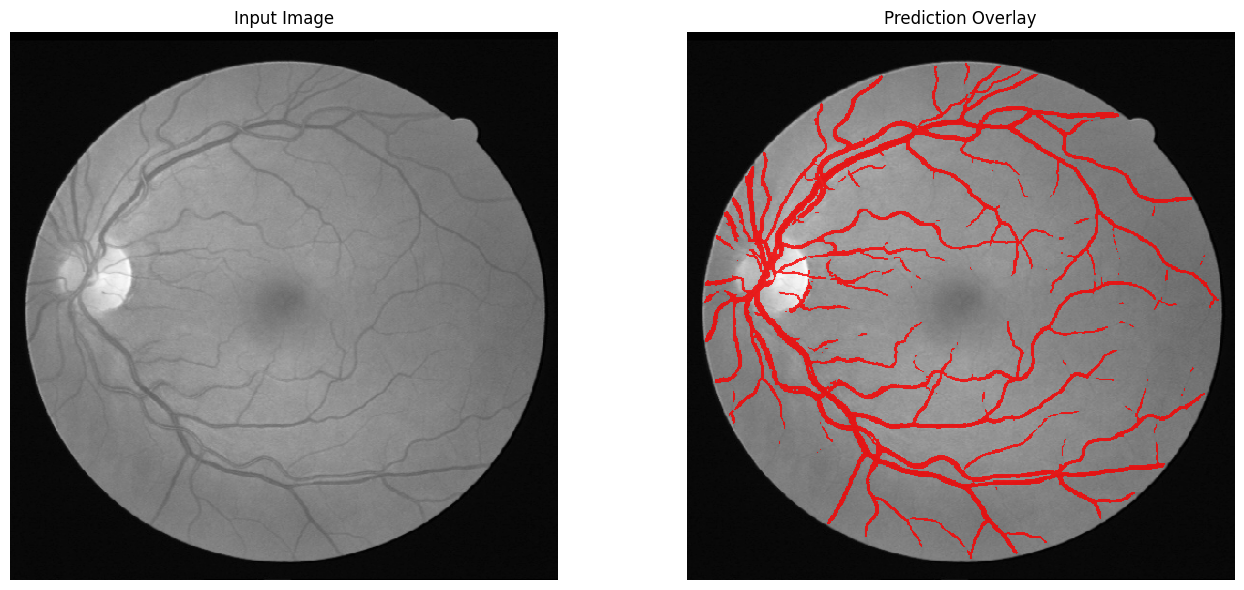

In [122]:
# Test dataset for now obtained from the training one (train_dict_list in monai.data.CacheDataset to obtain test_dataset) bacause the test dataset does not have useful masks
test_transform = monai.transforms.Compose([
    LoadVesselData(),  # ensures float32
    #monai.transforms.AddChanneld(keys=['img'])   #, 'mask']),
        #monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        #monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
    ###monai.transforms.EnsureTyped(keys=['img', 'mask'], dtype=torch.float32),  # Explicitly convert
])


test_dataset = monai.data.CacheDataset(test_dict_list, transform=test_transform)
test_loader = monai.data.DataLoader(test_dataset, batch_size=1)


for sample in test_loader:
    print("Test Image dtype:", sample["img"].dtype)  # Should be torch.float32
    #print("Test Mask dtype:", sample["mask"].dtype)  # Should be torch.float32
    print("Test Image shape:", sample["img"].shape)  # Should be [1, 1, 512, 512]
    break


for sample in test_loader:
    visual_evaluation_nomask_ensemble(sample, best_saved_models,device)
    break

In [74]:
#test_outputs = compute_test_predictions_weighted(test_loader, model_dice_dict, device)
#print(f"Test set predictions computed for {len(test_outputs)} images")

# Export Predictions for the Grand-Challenge
https://drive.grand-challenge.org/evaluation/submissions/


In [123]:
models_for = config["ensemble_models"]
str_models = "___".join(models_for)

In [124]:
test_transform = Compose([
    LoadTestData(),  # Your MONAI-compatible test loader
    EnsureTyped(keys=["img"], allow_missing_keys=True)

])

save_outputs = '/'.join(config['save_model'].split('/')[:-1])  # e.g., '../saved_outputs'
os.makedirs(save_outputs, exist_ok=True)

save_path = f"{config['save_path']}_{str_models}"
zip_filename = f"{config['zip_filename']}_{str_models}.zip"
os.makedirs(save_path, exist_ok=True)

# 3. Ensemble Inference & Save Output Images
forced_size = (584, 565)  # original image shape
threshold_val = 0.5

print("🧠 Running ensemble prediction and saving masks...")
for i, sample in enumerate(tqdm(test_loader), 1):
    image = sample["img"].to(device)

    if image.dim() == 3:
        image = image.unsqueeze(0)  # [1, 1, H, W]

    with torch.no_grad():
        preds = []
        for m in best_saved_models:
            m.eval()
            out = m(image)
            probs = torch.sigmoid(out)
            preds.append(probs.cpu())

        combined = torch.stack(preds).mean(dim=0)  # [1, 1, H, W]
        binary_mask = (combined > threshold_val).float()

    # Resize output mask to original shape
    resized_mask = F.interpolate(binary_mask, size=forced_size, mode='nearest')
    resized_mask_np = resized_mask.squeeze().cpu().numpy().astype(np.uint8) * 255

    # Save image
    filename = os.path.join(save_path, f"{i}.png")
    cv2.imwrite(filename, resized_mask_np)

print(f"✅ Saved all ensemble masks to: {save_path}")

# 4. Zip all saved images
print("📦 Creating zip archive...")
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in os.listdir(save_path):
        if file.endswith(".png"):
            zipf.write(os.path.join(save_path, file), arcname=file)

print(f"✅ Zip file created: {zip_filename}")

# 5. Optionally delete individual images
print("🧹 Cleaning up PNG files...")
for file in os.listdir(save_path):
    file_path = os.path.join(save_path, file)
    if file.endswith(".png") and os.path.isfile(file_path):
        os.remove(file_path)

os.rmdir(save_path)
print(f"✅ Cleaned up image files from: {save_path}")


🧠 Running ensemble prediction and saving masks...


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]

✅ Saved all ensemble masks to: ../saved_outputs/output_images_swin_model___dropout_UNet
📦 Creating zip archive...
✅ Zip file created: ../saved_outputs/segmentation_outputs_swin_model___dropout_UNet.zip
🧹 Cleaning up PNG files...
✅ Cleaned up image files from: ../saved_outputs/output_images_swin_model___dropout_UNet


## robe per grafici

Test Image dtype: torch.float32
Test Image shape: torch.Size([1, 1, 512, 512])


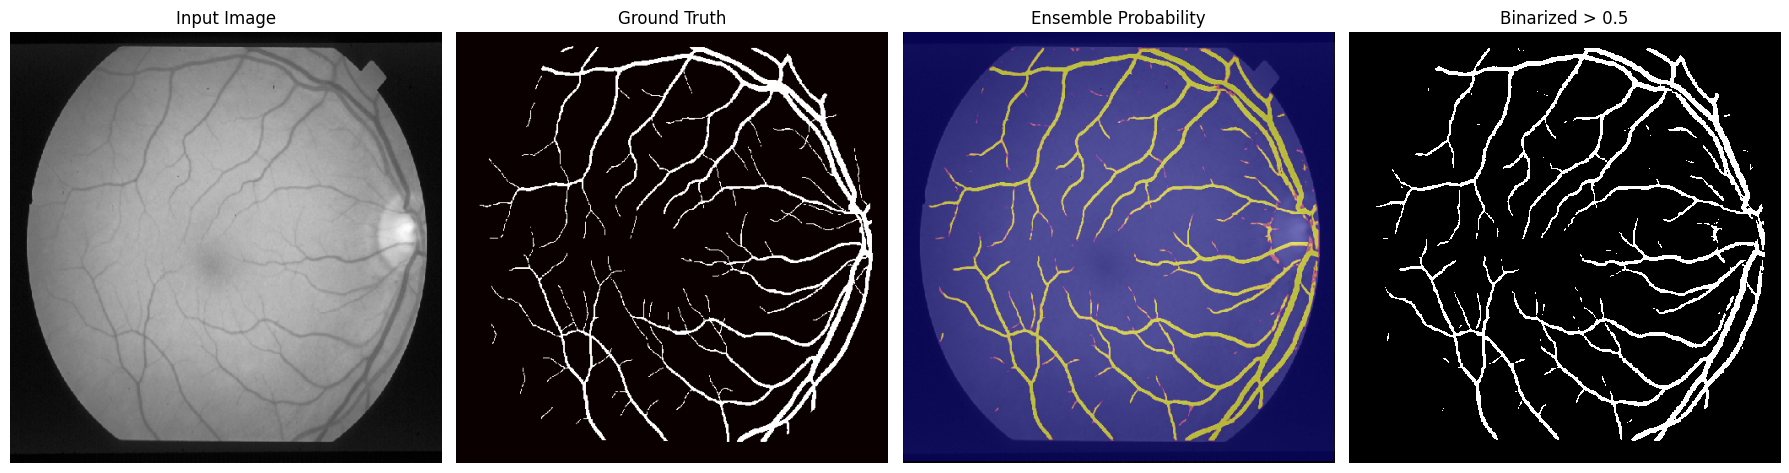

In [38]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import monai

def visual_evaluation_4panels_ensemble(sample, models, device, method='average', threshold_val=0.5):
    """
    Visual evaluation with an ensemble (4 subplots):
      1) Input image
      2) Ground truth (if present)
      3) Ensemble probability map
      4) Binarized ensemble output
    
    Args:
        sample (dict): A dictionary with keys at least "img". Optionally "mask" and "valid_mask".
        models (list): List of PyTorch models for the ensemble.
        device (torch.device): Where models are loaded (CPU/CUDA).
        method (str): 'average' or 'vote' for ensemble combination.
        threshold_val (float): Threshold to binarize probability map.
    """
    sigmoid = torch.nn.Sigmoid()
    threshold_monai = monai.transforms.AsDiscrete(threshold_values=True)

    # 1) Prepare input image
    img_tensor = sample["img"].float().to(device)
    if img_tensor.dim() == 3:
        # shape [1, H, W] → add batch dimension
        img_tensor = img_tensor.unsqueeze(0)  # [B=1, C=1, H, W]
    img_np = sample["img"].squeeze().cpu().numpy()  # for plotting

    # 2) Optional ground truth
    has_gt = ("mask" in sample)

    # 3) Ensemble inference
    with torch.no_grad():
        preds = []
        for model in models:
            model.eval()
            output = model(img_tensor)       # raw logits shape: [1, 1, H, W]
            probs = sigmoid(output)          # convert to probabilities
            preds.append(probs.cpu())

        # Combine ensemble predictions
        if method == 'average':
            # Soft probability average
            combined = torch.stack(preds).mean(dim=0)  # [1, 1, H, W]
        elif method == 'vote':
            # majority vote among binarized preds
            binarized = [threshold_monai(p) for p in preds]  # each is 0 or 1
            combined = torch.stack(binarized).float().mean(dim=0)
            # combined is in [0..1], e.g. 0.6 means 3 of 5 models said "1"
        else:
            raise ValueError(f"Unsupported ensemble method: {method}")

    # Convert to NumPy
    combined_probs_np = combined.squeeze().numpy()  # shape [H, W], values in [0..1]
    
    # 4) Optionally apply valid_mask
    if "valid_mask" in sample:
        valid = sample["valid_mask"].squeeze().cpu().numpy()
        combined_probs_np *= valid

    # 5) Binarize final ensemble
    combined_bin_np = (combined_probs_np > threshold_val).astype(np.uint8)

    # ----- Plotting -----
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))

    # (A) Input Image
    axes[0].imshow(img_np, cmap='gray')
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # (B) Ground Truth (if present)
    if has_gt:
        gt_np = sample["mask"].squeeze().cpu().numpy()
        axes[1].imshow(gt_np, cmap='hot')
        axes[1].set_title("Ground Truth")
    else:
        axes[1].text(0.5, 0.5, "No GT Provided",
                     ha="center", va="center", fontsize=12)
    axes[1].axis("off")

    # (C) Ensemble Probability
    # show continuous [0..1] map
    #axes[2].imshow(combined_probs_np, cmap='plasma', vmin=0.1, vmax=0.8)
    masked_probs = np.ma.masked_where(valid == 0, combined_probs_np)
    axes[2].imshow(img_np, cmap='gray')
    axes[2].imshow(masked_probs, cmap='plasma', alpha=0.6)
    
    axes[2].set_title("Ensemble Probability")
    axes[2].axis("off")

    # (D) Binarized Ensemble
    axes[3].imshow(combined_bin_np, cmap='gray', interpolation='none')
    axes[3].set_title(f"Binarized > {threshold_val}")
    axes[3].axis("off")

    plt.tight_layout()
    plt.savefig("ensemble_4panel_sample.png", bbox_inches='tight', dpi=300)

    plt.show()

val_loader = monai.data.DataLoader(val_dataset, batch_size=1)


for sample in val_loader:
    print("Test Image dtype:", sample["img"].dtype)  # Should be torch.float32
    #print("Test Mask dtype:", sample["mask"].dtype)  # Should be torch.float32
    print("Test Image shape:", sample["img"].shape)  # Should be [1, 1, 512, 512]
    break
    
for sample in val_loader:
    visual_evaluation_4panels_ensemble(sample, best_saved_models, device, method='average', threshold_val=0.5)
    break


🔍 Showing Sample 7


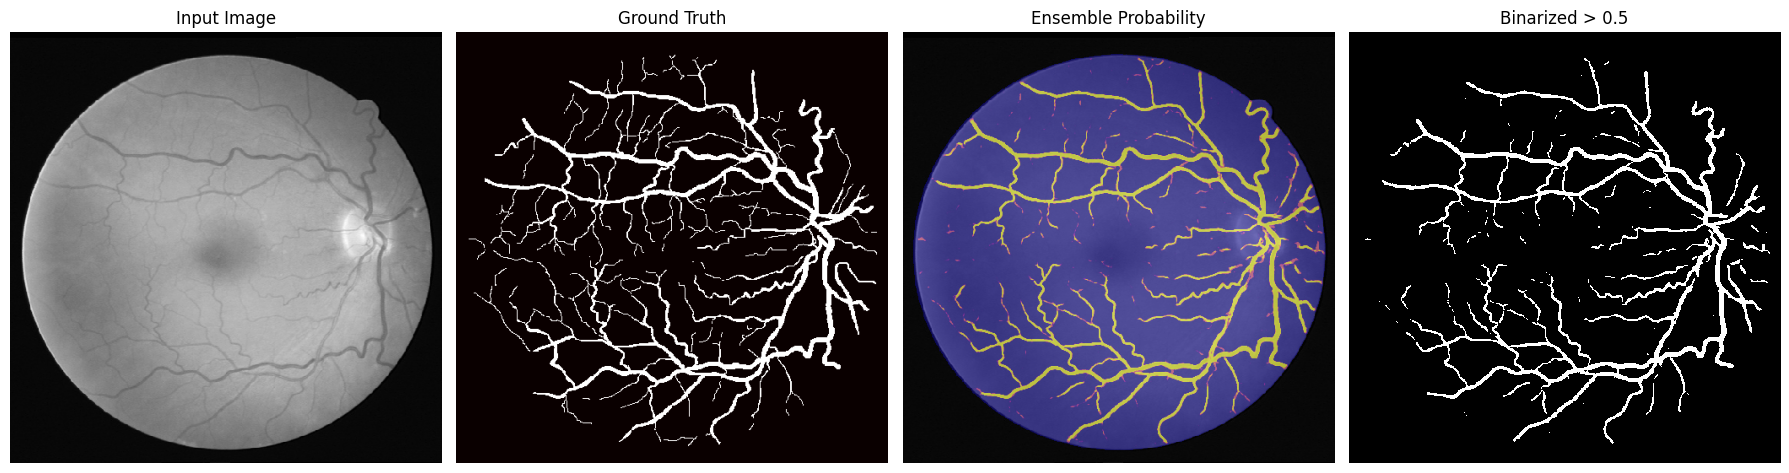

In [39]:
for i, sample in enumerate(val_loader):
    if i == 6:
        print(f"🔍 Showing Sample {i + 1}")
        visual_evaluation_4panels_ensemble(sample, best_saved_models, device, method='average', threshold_val=0.5)
        break


<hr>

### Secret test dataset

In [108]:
def build_dict_vessels(data_path, mode='training'):
    """
    Builds a list of dictionaries containing paths to images, segmentation masks (if available),
    and valid region masks (if available) for the DRIVE-like dataset.

    Returns:
        List[Dict[str, str]]: Each dict contains keys:
            'img'         → path to image
            'mask'        → path to vessel segmentation (optional)
            'valid_mask'  → path to field-of-view mask (optional)
    """
    if mode not in ["training", "test"]:
        raise ValueError(f"Please choose a mode in ['training', 'test']. Current mode is '{mode}'.")

    dicts = []
    image_glob = os.path.join(data_path, mode, '*.tif')
    paths_retina = sorted(glob.glob(image_glob))

    print(f"🔎 Found {len(paths_retina)} images in: {image_glob}")

    for retina_path in paths_retina:
        filename = os.path.basename(retina_path)
        image_index = filename.split('_')[0].split('.')[0]  # handles both "01_test.tif" and "53_secret.tif"

        mask_path = os.path.join(data_path, mode, '1st_manual', f'{image_index}_manual1.gif')
        padding_mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}_{mode}_mask.gif')

        entry = {'img': retina_path,
                 'name': filename}

        if os.path.exists(mask_path):
            entry['mask'] = mask_path
        if os.path.exists(padding_mask_path):
            entry['valid_mask'] = padding_mask_path

        dicts.append(entry)

    if not dicts:
        print("⚠️ No usable samples were found. Check your folder structure or file names.")

    return dicts


secret_dataset = "../datasets/drive_secret/"
new_test_dict_list = build_dict_vessels(secret_dataset, mode='test')
if os.path.exists(secret_dataset):
    print(" exist")
    for i in os.listdir(secret_dataset):
        print(i)
        break
    
print(f'Number of samples in the test dataset: {len(new_test_dict_list)}')


#########à
from monai.transforms import Compose, EnsureTyped

test_transform = Compose([
    LoadVesselData(),
    EnsureTyped(keys=["img"], allow_missing_keys=True)
])

new_test_dataset = monai.data.CacheDataset(new_test_dict_list, transform=test_transform)

#########


test_loader = monai.data.DataLoader(new_test_dataset, batch_size=1)


def run_ensemble_inference_and_save(config, str_models, test_loader, best_saved_models, device, forced_size=(605, 700), threshold_val=0.5):
    """
    Runs ensemble inference on test_loader, saves binarized masks with original names,
    zips them, and deletes individual files after archiving.

    Args:
        config (dict): Config dictionary containing 'save_model', 'save_path', 'zip_filename'
        str_models (str): Identifier string for the ensemble model
        test_loader (DataLoader): DataLoader for test set
        best_saved_models (list): List of loaded PyTorch models
        device (torch.device): Device to run inference on
        forced_size (tuple): Final size to resize prediction masks to (H, W)
        threshold_val (float): Threshold to binarize the prediction
    """
    save_outputs = '/'.join(config['save_model'].split('/')[:-1])  # parent of save_model
    os.makedirs(save_outputs, exist_ok=True)

    save_path = f"{config['save_path']}_{str_models}_secret_dataset"
    zip_filename = f"{config['zip_filename']}_{str_models}__secret_dataset.zip"
    os.makedirs(save_path, exist_ok=True)

    print("🧠 Running ensemble prediction and saving masks...")
    for i, sample in enumerate(tqdm(test_loader), 1):
        image = sample["img"].to(device)

        if image.dim() == 3:
            image = image.unsqueeze(0)  # [1, 1, H, W]

        with torch.no_grad():
            preds = []
            for m in best_saved_models:
                m.eval()
                out = m(image)
                probs = torch.sigmoid(out)
                preds.append(probs.cpu())

            combined = torch.stack(preds).mean(dim=0)
            binary_mask = (combined > threshold_val).float()

        # Resize output mask
        resized_mask = F.interpolate(binary_mask, size=forced_size, mode='nearest')
        resized_mask_np = resized_mask.squeeze().cpu().numpy().astype(np.uint8) * 255

        # Save image with original name
        original_name = sample["name"][0] if isinstance(sample["name"], list) else sample["name"]
        filename = os.path.join(save_path, original_name.replace('.tif', '.png'))
        cv2.imwrite(filename, resized_mask_np)

    print(f"✅ Saved all ensemble masks to: {save_path}")

    # Zip all saved images
    print("📦 Creating zip archive...")
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in os.listdir(save_path):
            if file.endswith(".png"):
                zipf.write(os.path.join(save_path, file), arcname=file)

    print(f"✅ Zip file created: {zip_filename}")

    # Clean up individual PNGs
    print("🧹 Cleaning up PNG files...")
    for file in os.listdir(save_path):
        file_path = os.path.join(save_path, file)
        if file.endswith(".png") and os.path.isfile(file_path):
            os.remove(file_path)

    os.rmdir(save_path)
    print(f"✅ Cleaned up image files from: {save_path}")


run_ensemble_inference_and_save(config, str_models, test_loader, best_saved_models, device)


🔎 Found 20 images in: ../datasets/drive_secret/test/*.tif
 exist
53_secret.tif
Number of samples in the test dataset: 20


Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 312.56it/s]


🧠 Running ensemble prediction and saving masks...


100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

✅ Saved all ensemble masks to: ../saved_outputs/output_images_swin_model___dropout_UNet_secret_dataset
📦 Creating zip archive...
✅ Zip file created: ../saved_outputs/segmentation_outputs_swin_model___dropout_UNet__secret_dataset.zip
🧹 Cleaning up PNG files...
✅ Cleaned up image files from: ../saved_outputs/output_images_swin_model___dropout_UNet_secret_dataset


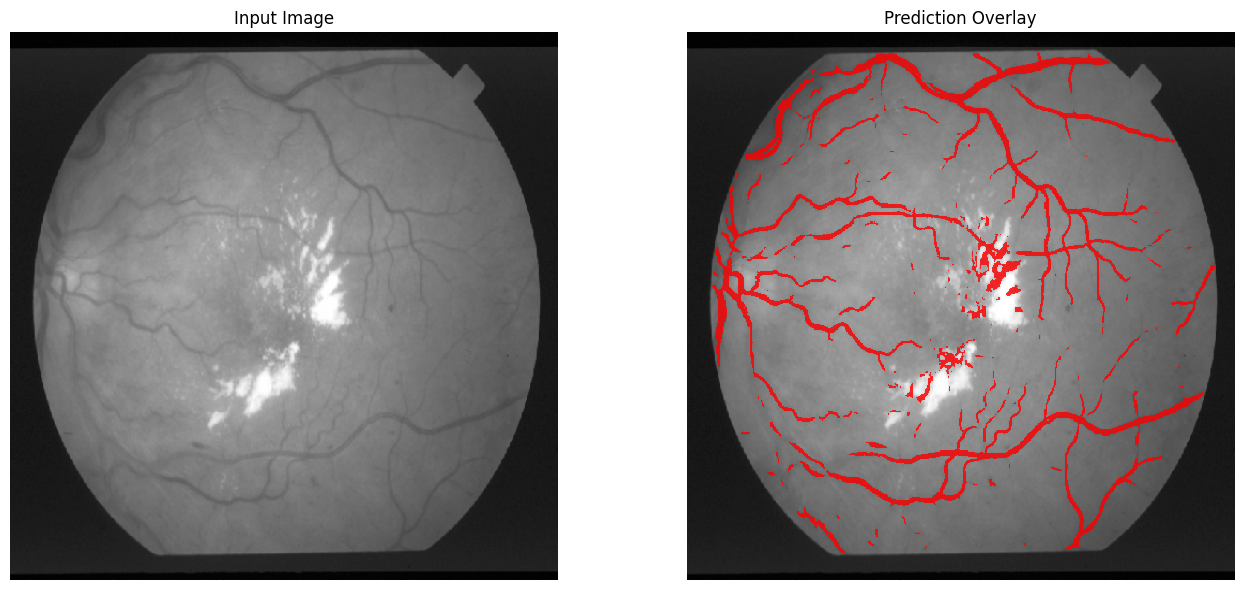

In [100]:
for sample in test_loader:
    visual_evaluation_nomask_ensemble(sample, best_saved_models,device)
    break